In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pylab as plt
import pandas as pd

In [44]:
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['figure.subplot.bottom'] = 0.15
plt.rcParams['figure.subplot.left'] = 0.2
plt.rcParams["font.size"]=10


In [18]:
kb=1.38e-23
NA=6.02e23
e=1.6e-19

def calcProp(T,p):
    ret=pd.DataFrame([T],columns=["T"])
    ret["p"]=p
    ret["Mw"]=0.8*28+0.2*32
    ret["m"]=ret["Mw"]/NA*1e-3
    ret["rhof"]=ret["p"]/kb/NA/ret["T"]
    ret["mu"]=1.716e-5*(ret["T"]/273.0)**1.5*(273.0+111)/(ret["T"]+111)
    ret["lambda"]=ret["mu"]/ret["p"]*(np.pi*kb*ret["T"]*0.5/ret["m"])**0.5

    return ret
    
pp=calcProp(293.15,1.013e5)


In [48]:
# particle volume
def Dp2V(dp,pp):
	return dp*dp*dp/6.0*np.pi

# particle cross section
def Dp2A(dp,pp):
	return dp*dp*0.25*np.pi

# particle diameter to Chaningham's slip factor
def Dp2Cc(dp,pp):
	ap=dp/2.0
	return 1+pp["lambda"][0]/ap*(1.257+0.4*np.exp(-1.1*ap/pp["lambda"][0]))

# particle diameter to relaxation time (Stokes)
def Dp2Tau(dp,rhop,pp):
    return Dp2Cc(dp,pp)*dp*dp*rhop/18.0/pp["mu"][0]

# Particle Reynolds number
def Re(dp,v,pp):
    return dp*v*pp["rhof"][0]/pp["mu"][0]

# Stokes number
def Stk(dp,rhop,v,L,pp):
    return Dp2Tau(dp,rhop,pp)*v/L

# Drag coefficient (Stokes)
def CdStokes(dp,v,pp):
    return 24/Re(dp,v,pp)/Dp2Cc(dp,pp)

# Drag force (Stokes)
def FdStokes(dp,v,rhop,pp):
    return 0.5*v*v*rhop*Dp2A(dp,pp)*CdStokes(dp,v,pp)



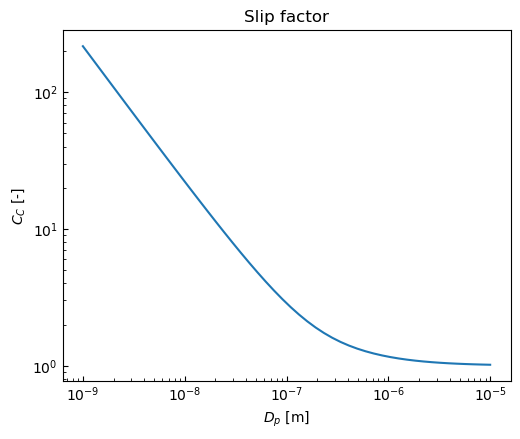

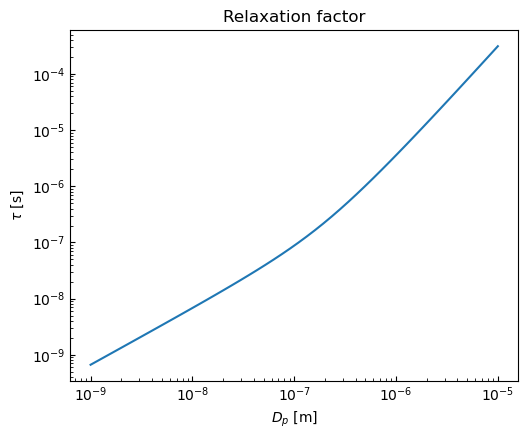

In [51]:
dp=np.logspace(-9,-5)
rhop=1000

plt.plot(dp,Dp2Cc(dp,pp))
plt.xscale("log"), plt.yscale("log")
plt.xlabel(r"$D_p$ [m]"), plt.ylabel(r"$C_C$ [-]"), plt.title("Slip factor")
plt.show()

plt.plot(dp,Dp2Tau(dp,rhop,pp))
plt.xscale("log"), plt.yscale("log")
plt.xlabel(r"$D_p$ [m]"), plt.ylabel(r"$\tau$ [s]"), plt.title("Relaxation factor")
plt.show()

## Relationships of $V$-$D_p$-$Z_p$
$$
Z_p=\frac{C_C e}{3 \pi \mu D_p} \\
Z_p=\frac{2Q_{sh}}{4 \pi L V}\log \left( \frac{R_{out}}{R_{in}} \right) \\
C_C=1+\frac{2 \lambda}{D_p} \left[ A_1+A_2 \exp \left( A_3 \frac{D_p}{2 \lambda} \right) \right]
$$

|Symbol|Definition|unit(SI)|
|----|----|----|
|$Z_p$|Electrical mobility|$m^2 V^{-1} s^{-1}$|
|$D_p$|Particle diameter|$m$|
|$V$|DMA voltage|$V$|
|$e$|Elementary charge|$C$|
|$\mu$|Viscosity|$Pa s$|
|$\lambda$|Mean free path|$m$|
|$Q_{sh}$|DMA sheath gas flow rate|$m^3 s^{-1}$|
|$L$|DMA classification length|$m$|
|$R_{out}$|DMA outer diameter|$m$|
|$R_{in}$|DMA inner diameter|$m$|
|$A_1,A_2,A_3$|Coefficients of slip factor|-|

In [37]:
# particle diameter to electrical mobility
def Dp2Zp(dp,pp):
	Cc=Dp2Cc(dp,pp)
	return Cc*e/(3*np.pi*pp["mu"][0]*dp)

# voltage to electrical mobility
def V2Zp(V,DMA,pp):
	ratio=DMA["Rout"][0]/DMA["Rin"][0]
	coeff=2*DMA["Qsh"][0]*np.log(ratio)/(4.0*np.pi*DMA["L"][0])
	return coeff/V

# voltage to particle diameter
def V2Dp(V,DMA,pp):
	def dZp(dp):
		Zp1=V2Zp(V,DMA,pp)
		Zp2=Dp2Zp(dp,pp)
		return ((Zp2-Zp1)*1e10)**2
	result=minimize(dZp,6e-8,method="Nelder-Mead")
	return result.x[0]

# electrical mobility to particle diameter
def Zp2Dp(Zp1,pp):
	def dZp(dp):
		Zp2=Dp2Zp(dp,pp)
		return ((Zp2-Zp1)*1e10)**2
	result=minimize(dZp,6e-8,method="Nelder-Mead")
	return result.x[0]


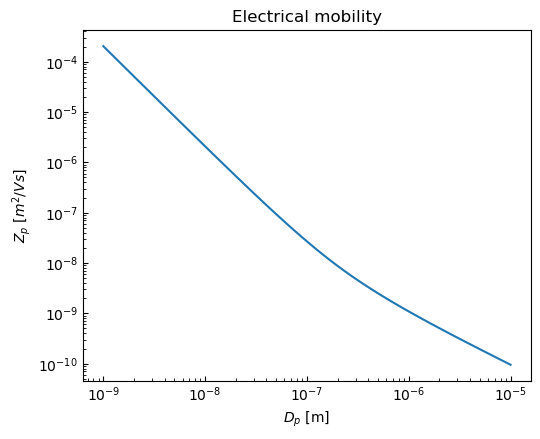

In [54]:
DMA=pd.DataFrame([[15/6e4,2e-3,4e-3,10e-3]]
                 ,columns=["Qsh","Rin","Rout","L"],index=None)
dp=np.logspace(-9,-5)
rhop=1000

plt.plot(dp,Dp2Zp(dp,pp))
plt.xscale("log"), plt.yscale("log")
plt.xlabel(r"$D_p$ [m]"), plt.ylabel(r"$Z_p$ [$m^2/Vs$]"), plt.title("Electrical mobility")
plt.show()